# Building RAG-based LLM Applications for Production

- **Blog post**: https://www.anyscale.com/blog/a-comprehensive-guide-for-building-rag-based-llm-applications-part-1
- **GitHub repository**: https://github.com/ray-project/llm-applications
- **Anyscale Endpoints**: https://endpoints.anyscale.com/
- **Ray documentation**: https://docs.ray.io/

In this guide, we will learn how to:
- 💻 Develop a retrieval augmented generation (RAG) based LLM application.
- 🚀 Scale the major components (load, chunk, embed, index, serve, etc.) in our application.
- ✅ Evaluate different configurations of our application to optimize for both per-component (ex. retrieval_score) and overall performance (quality_score).
- 🔀 Implement an agent routing approach to bridge the gap b/w OSS and closed LLMs.
- 📦 Serve the application in a highly scalable and available manner.
- 💥 Share the 1st order and 2nd order impact LLM applications can have for your team.

# Overview

Large language models (LLMs) have undoubtedly changed the way we interact with information. However, they come with their fair share of limitations as to what we can ask of them. Base LLMs (ex. Llama-2-70b, gpt-4, etc.) are only aware of the information that they've been trained on and will fall short when we require them to know information beyond that. Retrieval augmented generation (RAG) based LLM applications address this exact issue and extend the utility of LLMs and their generative reasoning abilities to our unique datasets. 

In this guide, we're going to build a RAG-based LLM application where we will incorporate external data sources to augment our LLM’s capabilities. Specifically, we will be building an assistant that can answer questions about [Ray](https://github.com/ray-project/ray) — a Python framework for productionizing and scaling ML workloads. The goal here is to make it easier for developers to adopt Ray, but also, as we'll see in this guide, to help improve our Ray documentation itself and provide a foundation for other LLM applications. We’ll also share challenges we faced along the way and how we overcame them.

**Note**: We have generalized this entire guide so that it can easily be extended to build RAG-based LLM applications on top of your own data.

<img width="500" src="https://images.ctfassets.net/xjan103pcp94/4PX0l1ruKqfH17YvUiMFPw/c60a7a665125cb8056bebcc146c23b76/image8.png">

Besides just building our LLM application, we’re also going to be focused on scaling and serving it in production. Unlike traditional machine learning, or even supervised deep learning, scale is a bottleneck for LLM applications from the very beginning. Large datasets, models, compute intensive workloads, serving requirements, etc. We’ll develop our application to be able to handle any scale as the world around us continues to grow. We’re also going to be focused on evaluation and performance. Our application involves many moving pieces: embedding models, chunking logic, the LLM itself, etc. and so it's important that we experiment with different configurations to optimize for the best quality responses. However, it's non-trivial to evaluate and quantitatively compare different configurations for a generative task. We’re going to break down evaluation of individual parts of our application (retrieval given query, generation given source), also assess the overall performance (end-to-end generation) and share findings towards an optimized configuration.

**Note**: We'll be experimenting with different LLMs (OpenAI, Llama, etc.) in this guide. You will need [OpenAI credentials](https://platform.openai.com/account/api-keys) to access [ChatGPT models](https://platform.openai.com/docs/models/) and [Anyscale Endpoints](https://endpoints.anyscale.com/) (public and private endpoints available) to access + fine-tune OSS LLMs.

## Set up

We're going to start by setting up our base imports, directories and initializing Ray with credentials. We'll be using [Ray](https://docs.ray.io/) to easily scale our workloads with minimal changes to our code.

In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()

True

In [3]:
from rag.config import ROOT_DIR

In [4]:
# Credentials
ray.init(runtime_env={
    "env_vars": {
        "OPENAI_API_BASE": os.environ["OPENAI_API_BASE"],
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"], 
        "ANYSCALE_API_BASE": os.environ["ANYSCALE_API_BASE"],
        "ANYSCALE_API_KEY": os.environ["ANYSCALE_API_KEY"],
        "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
    "working_dir": str(ROOT_DIR)
})

2023-10-09 18:22:54,934	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 10.0.10.194:6379...
2023-10-09 18:22:54,971	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at https://session-5ljni527x7edt2q6px7nuaejct.i.anyscaleuserdata-staging.com 
2023-10-09 18:22:55,035	INFO packaging.py:518 -- Creating a file package for local directory '/home/ray/ray-assistant/notebooks/..'.
2023-10-09 18:22:55,128	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_68de1c79e4ea5f4a.zip' (21.08MiB) to Ray cluster...
2023-10-09 18:22:55,199	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_68de1c79e4ea5f4a.zip'.


Python version:,3.10.8
Ray version:,2.7.0
Dashboard:,http://session-5ljni527x7edt2q6px7nuaejct.i.anyscaleuserdata-staging.com


In [5]:
ray.cluster_resources()

{'memory': 34359738368.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 8.0,
 'object_store_memory': 9500233728.0,
 'node:10.0.10.194': 1.0,
 'accelerator_type:A10G': 1.0}

We've also created some mappings for the different embedding and language models we'll be developing with in our application:

In [6]:
from rag.config import EMBEDDING_DIMENSIONS, MAX_CONTEXT_LENGTHS

In [7]:
# Embedding dimensions
EMBEDDING_DIMENSIONS

{'thenlper/gte-base': 768,
 'thenlper/gte-large': 1024,
 'BAAI/bge-large-en': 1024,
 'text-embedding-ada-002': 1536,
 'gte-large-fine-tuned': 1024}

In [8]:
# LLM context lengths (1 token = 3/4 word)
MAX_CONTEXT_LENGTHS

{'gpt-4': 8192,
 'gpt-3.5-turbo': 4096,
 'gpt-3.5-turbo-16k': 16384,
 'meta-llama/Llama-2-7b-chat-hf': 4096,
 'meta-llama/Llama-2-13b-chat-hf': 4096,
 'meta-llama/Llama-2-70b-chat-hf': 4096,
 'codellama/CodeLlama-34b-Instruct-hf': 16384}

## Data

Before we can start building our RAG application, we need to first create our vector DB that will contain our processed data sources.

<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/3q5HUANQ4kS0V23cgEP0JF/ef3b62c5bc5c5c11b734fd3b73f6ea28/image3.png">

### Load data

In [9]:
from pathlib import Path
from rag.config import EFS_DIR

We need to first download the [Ray documentation](https://docs.ray.io/) to a directory:
```bash
export EFS_DIR=/desired/output/directory
wget -e robots=off --recursive --no-clobber --page-requisites \
  --html-extension --convert-links --restrict-file-names=windows \
  --domains docs.ray.io --no-parent --accept=html \
  -P $EFS_DIR https://docs.ray.io/en/master/
```

We’re going to then load our docs contents into a [Ray Dataset](https://docs.ray.io/en/latest/data/data.html) so that we can perform operations at scale on them (ex. embed, index, etc.). With large data sources, models and application serving needs, scale is a day-1 priority for LLM applications. We want to build our applications in such a way that they can scale as our needs grow without us having to change our code later.

In [10]:
# Ray dataset
DOCS_DIR = Path(EFS_DIR, "docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in DOCS_DIR.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3282 documents


### Sections

Now that we have a dataset of all the paths to the html files, we're going to develop some functions that can appropriately extract the content from these files. We want to do this in a generalized manner so that we can perform this extraction across all of our docs pages (and so you can use it for your own data sources). Our process is to first identify the sections in our html page and then extract the text in between them. We save all of this into a list of dictionaries that map the text within a section to a specific url with a section anchor id.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/1eFnKmG5xqPIFtPupZ327X/f6152723e18322b90aaa8be5d2d5a6e4/image5.png">

In [11]:
import matplotlib.pyplot as plt
from rag.data import extract_sections

In [12]:
sample_html_fp = Path(EFS_DIR, "docs.ray.io/en/master/rllib/rllib-env.html")
extract_sections({"path": sample_html_fp})[0]

{'source': 'https://docs.ray.io/en/master/rllib/rllib-env.html#environments',
 'text': '\nEnvironments#\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\nTip\nNot all environments work with all algorithms. Check out the algorithm overview for more information.\n'}

We can apply this extraction process (extract_section) in parallel to all the file paths in our dataset with just one line using Ray Data's [flat_map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.flat_map.html):

In [13]:
# Extract sections
sections_ds = ds.flat_map(extract_sections)
sections_ds.count()

2023-10-09 18:23:02,434	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)]
2023-10-09 18:23:02,435	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 18:23:02,435	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

5727

In [14]:
section_lengths = []
for section in sections_ds.take_all():
    section_lengths.append(len(section["text"]))

2023-10-09 18:23:26,221	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune


### Chunk data

We now have a list of sections (with text and source of each section) but we shouldn't directly use this as context to our RAG application just yet. The text lengths of each section are all varied and many are quite large chunks. 

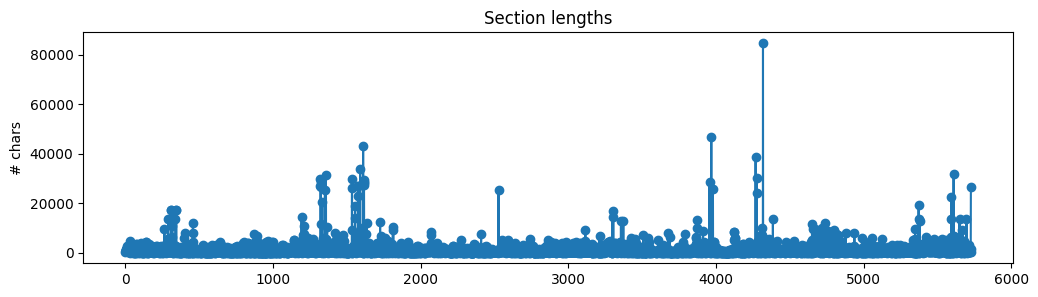

In [15]:
# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

If we were to use these large sections, then we'd be inserting a lot of noisy/unwanted context and because all LLMs have a maximum context length, we wouldn't be able to fit too much other relevant context. So instead, we're going to split the text within each section into smaller chunks. Intuitively, smaller chunks will encapsulate single/few concepts and will be less noisy compared to larger chunks. We're going to choose some typical text splitting values (ex. chunk_size=300) to create our chunks for now but we'll be experimenting with a wider range of values later.

In [16]:
from functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [17]:
# Text splitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len)

In [18]:
# Chunk a sample section
sample_section = sections_ds.take(1)[0]
chunks = text_splitter.create_documents(
    texts=[sample_section["text"]], 
    metadatas=[{"source": sample_section["source"]}])
print (chunks[0])

2023-10-09 18:23:26,611	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-10-09 18:23:26,613	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections->Limit[1])] -> LimitOperator[limit=1]
2023-10-09 18:23:26,614	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 18:23:26,615	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

page_content='Ray Dashboard#\nRay provides a web-based dashboard for monitoring and debugging Ray applications.\nThe visual representation of the system state, allows users to track the performance\nof applications and troubleshoot issues.' metadata={'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard'}


While chunking our dataset is relatively fast, let’s wrap the chunking logic into a function so that we can apply the workload at scale so that chunking remains just as fast as our data sources grow:


In [19]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section["text"]], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [20]:
# Scale chunking
chunks_ds = sections_ds.flat_map(partial(
    chunk_section, 
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap))
print(f"{chunks_ds.count()} chunks")
chunks_ds.show(1)

2023-10-09 18:23:26,879	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)]
2023-10-09 18:23:26,880	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 18:23:26,881	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-10-09 18:23:49,006	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial->Limit[1])] -> LimitOperator[limit=1]
2023-10-09 18:23:49,007	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 18:23:49,007	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


32276 chunks


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'text': 'Reference#\nMonitor and debug your Ray applications and clusters using the API and CLI documented in these references.\nThe guides include:\nState API\nState CLI\nSystem Metrics', 'source': 'https://docs.ray.io/en/master/ray-observability/reference/index.html#reference'}


### Embed data

Now that we've created small chunks from our sections, we need a way to identify the most relevant ones for a given query. A very effective and quick method is to embed our data using a pretrained model and use the same model to embed the query. We can then compute the distance between all of the chunk embeddings and our query embedding to determine the top-k chunks. There are many different pretrained models to choose from to embed our data but the most popular ones can be discovered through [HuggingFace's Massive Text Embedding Benchmark (MTEB)](https://huggingface.co/spaces/mteb/leaderboard) leaderboard. These models were pretrained on very large text corpus through tasks such as next/masked token prediction which allowed them to learn to represent sub-tokens in N dimensions and capture semantic relationships. We can leverage this to represent our data and identify the most relevant contexts to use to answer a given query. We're using Langchain's Embedding wrappers ([HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html) and [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html)) to easily load the models and embed our document chunks.

**Note**: embeddings aren't the only way to determine the more relevant chunks. We could also use an LLM to decide! However, because LLMs are much larger than these embedding models and have maximum context lengths, it's better to use embeddings to retrieve the top k chunks. And then we could use LLMs on the fewer k chunks to determine the <k chunks to use as the context to answer our query. We could also use reranking (ex. [Cohere Rerank](https://txt.cohere.com/rerank/)) to further identify the most relevant chunks to use. We could also combine embeddings with traditional information retrieval methods such as keyword matching, which could be useful for matching for unique tokens that may potentially be lost when embedding sub-tokens.

In [21]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

In [22]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [23]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

Here we're able to embed our chunks at scale by using [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html). All we had to do was define the `batch_size` and the compute to use (we're using two workers, each with 1 GPU).

In [24]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=2))

In [23]:
# Sample
sample = embedded_chunks.take(1)
print ("embedding size:", len(sample[0]["embeddings"]))
print (sample[0]["text"])

2023-10-08 15:07:18,048	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks->Limit[1])] -> LimitOperator[limit=1]
2023-10-08 15:07:18,049	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-08 15:07:18,051	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-10-08 15:07:18,069	INFO actor_pool_map_operator.py:106 -- MapBatches(EmbedChunks->Limit[1]): Waiting for 2 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-08 15:07:29,168	WARNING actor_pool_map_operator.py:265 -- Your batch size is too large. Currently, your batch size is 100. Your dataset contains 90, and Ray Data tried to parallelize it across 2 actors. To parallelize this fully across all 2 actors, set batch size to not exceed `90 / 2 = 45`.


embedding size: 768
ray.tune.search.hyperopt.HyperOptSearch.add_evaluated_trials#
HyperOptSearch.add_evaluated_trials(trials_or_analysis: Union[Trial, List[Trial], ExperimentAnalysis], metric: str)#
Pass results from trials that have been evaluated separately.
This method allows for information from outside the


### Index data

Now that we have our embedded chunks, we need to index (store) them somewhere so that we can retrieve them quickly for inference. While there are many popular vector database options, we're going to use [Postgres with pgvector](https://github.com/pgvector/pgvector) for it's simplificty and performance. We'll create a table (`document`) and write the (`text`, `source`, `embedding`) triplets for each embedded chunk we have.

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/3z1ryYkOtUjj6N1IuavJPf/ae60dc4a10c94e2cc928c38701befb51/image2.png">

In [25]:
import psycopg
from pgvector.psycopg import register_vector

In [ ]:
%%bash
# Set up pgvector
bash ../setup-pgvector.sh

In [26]:
%%bash
# Drop table and load index
psql "$DB_CONNECTION_STRING" -c "DROP TABLE IF EXISTS document;"
sudo -u postgres psql -f ../migrations/vector-768.sql  # "thenlper/gte-base" dimension is 768
export SQL_DUMP_FP="/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql"
psql "$DB_CONNECTION_STRING" -f $SQL_DUMP_FP  # load
psql "$DB_CONNECTION_STRING" -c "SELECT count(*) FROM document;"  # num rows

NOTICE:  table "document" does not exist, skipping


DROP TABLE
CREATE TABLE
SET
SET
SET
SET
SET
 set_config 
------------
 
(1 row)

SET
SET
SET
SET
ALTER TABLE
ALTER TABLE
ALTER TABLE
ALTER TABLE
DROP SEQUENCE
DROP TABLE
DROP SEQUENCE
DROP TABLE
DROP EXTENSION
CREATE EXTENSION
COMMENT
SET
SET
CREATE TABLE
ALTER TABLE
CREATE SEQUENCE
ALTER TABLE
ALTER SEQUENCE
CREATE TABLE
ALTER TABLE
CREATE SEQUENCE
ALTER TABLE
ALTER SEQUENCE
ALTER TABLE
ALTER TABLE
COPY 40433
COPY 64552
 setval 
--------
  40433
(1 row)

 setval 
--------
  64552
(1 row)

ALTER TABLE
ALTER TABLE
 count 
-------
 64552
(1 row)



If we don't have an index saved already, we can index the data and save it:

In [27]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

And once again, we can use Ray Data’s [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) to perform this indexing in parallel:

In [26]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=28),
).count()

2023-09-07 13:54:40,013	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-09-07 13:54:40,014	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-07 13:54:40,015	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-07 13:54:40,041	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedChunks): Waiting for 2 pool actors to start...
2023-09-07 13:54:58,943	INFO actor_pool_map_operator.py:117 -- MapBatches(StoreResults): Waiting for 28 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-09-07 13:59:39,909	WARNING actor_pool_map_operator.py:267 -- To ensure full parallelization across an actor pool of size 28, the specified batch size should be at most 0. Your configured batch size for this operator was 128.


0

In [24]:
%%bash
# Save index
export SQL_DUMP_FP="/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql"
mkdir -p $(dirname "$SQL_DUMP_FP") && touch $SQL_DUMP_FP
sudo -u postgres pg_dump -c > $SQL_DUMP_FP  # save

## Retrieval

With our embedded chunks indexed in our vector database, we're ready to perform retrieval for a given query. We'll start by using the same embedding model we used to embed our text chunks to now embed the incoming query.

<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/1hKBrFU2lyR5LLebFyq2ZL/8845c36ff98eb47005338de6ab6dbf50/image14.png">

In [28]:
import json
import numpy as np

In [29]:
# Embed query
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
query = "What is the default batch size for map_batches?"
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

768

Then, we'll retrieve the top most revelant chunks by extracting the closest embedded chunks to our embedded query. We use cosine distance (`<=>`) but there are [many options](https://github.com/pgvector/pgvector#vector-operators) to choose from. Once we retrieve the top `num_chunks`, we can collect the text for each chunk and use it as context to generate a response.

In [30]:
# Get context
num_chunks = 5
with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, num_chunks))
        rows = cur.fetchall()
        context = [{"text": row[1]} for row in rows]
        sources = [row[2] for row in rows]

In [31]:
for i, item in enumerate(context):
    print (sources[i])
    print (item["text"])
    print ()

https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches
entire blocks as batches (blocks may contain different numbers of rows).
The actual size of the batch provided to fn may be smaller than
batch_size if batch_size doesn’t evenly divide the block(s) sent
to a given map task. Default batch_size is 4096 with “default”.

https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches
entire blocks as batches (blocks may contain different numbers of rows).
The actual size of the batch provided to fn may be smaller than
batch_size if batch_size doesn’t evenly divide the block(s) sent
to a given map task. Default batch_size is 4096 with “default”.

https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size
batch_size.
Note
The default batch size depends on your resource type. If you’re using CPUs,
the default batch size is 4096. If you’re using GPUs, you must specify an explic

Let's wrap this into a convenient function:

In [32]:
def get_sources_and_context(query, embedding_model, num_chunks):
    embedding = np.array(embedding_model.embed_query(query))
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, num_chunks))
            rows = cur.fetchall()
            context = [{"text": row[1]} for row in rows]
            sources = [row[2] for row in rows]
    return sources, context

## Generation

We can now use the context to generate a response from our LLM. Without this relevant context that we retrieved, the LLM may not have been able to accurately answer our question. And as our data grows, we can just as easily embed and index any new data and be able to retrieve it to answer questions.

<img width="500" src="https://images.ctfassets.net/xjan103pcp94/38I8en8Tyf0cM4LUhjygoq/739d456c80841b4c28fe80f73ea5856b/image16.png">

In [33]:
import openai
import time

In [34]:
from rag.generate import prepare_response
from rag.utils import get_credentials

In [35]:
def generate_response(
    llm, temperature=0.0, stream=True,
    system_content="", assistant_content="", user_content="", 
    max_retries=3, retry_interval=60):
    """Generate response from an LLM."""
    retry_count = 0
    api_base, api_key = get_credentials(llm=llm)
    while retry_count < max_retries:
        try:
            response = openai.ChatCompletion.create(
                model=llm,
                temperature=temperature,
                stream=stream,
                api_base=api_base,
                api_key=api_key,
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "assistant", "content": assistant_content},
                    {"role": "user", "content": user_content},
                ],
            )
            return prepare_response(response=response, stream=stream)

        except Exception as e:
            print(f"Exception: {e}")
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

**Note**: We’re using a temperature of 0.0 to enable reproducible experiments but you should adjust this based on your use case. For use cases that need to always be factually grounded, we recommend very low temperature values while more creative tasks can benefit from higher temperatures.

In [36]:
# Generate response
query = "What is the default batch size for map_batches?"
response = generate_response(
    llm="meta-llama/Llama-2-70b-chat-hf",
    temperature=0.0,
    stream=True,
    system_content="Answer the query using the context provided. Be succinct.",
    user_content=f"query: {query}, context: {context}")
# Stream response
for content in response:
    print(content, end='', flush=True)

 The default batch size for map_batches is 4096.

### Agent

Let's combine the context retrieval and response generation together into a convenient query agent that we can use to easily generate our responses. This will take care of setting up our agent (embedding and LLM model), as well as the context retrieval, and pass it to our LLM for response generation.

In [37]:
from rag.embed import get_embedding_model
from rag.utils import get_num_tokens, trim

In [38]:
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="meta-llama/Llama-2-70b-chat-hf", temperature=0.0, 
                 max_context_length=4096, system_content="", assistant_content=""):
        
        # Embedding model
        self.embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name, 
            model_kwargs={"device": "cuda"}, 
            encode_kwargs={"device": "cuda", "batch_size": 100})
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, num_chunks=5, stream=True):
        # Get sources and context
        sources, context = get_sources_and_context(
            query=query,
            embedding_model=self.embedding_model,
            num_chunks=num_chunks)
            
        # Generate response
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=stream,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
            "llm": self.llm,
        }
        return result

With this, we can use our RAG application in just a few lines:

In [39]:
embedding_model_name="thenlper/gte-base"
llm="meta-llama/Llama-2-7b-chat-hf"

In [40]:
query = "What is the default batch size for map_batches?"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
print("\n\n", json.dumps(result, indent=2))



 {
  "question": "What is the default batch size for map_batches?",
  "sources": [
    "https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches",
    "https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches",
    "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size",
    "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size",
    "https://docs.ray.io/en/master/data/batch_inference.html#configuring-batch-size"
  ],
  "answer": " The default batch size for `map_batches` is 4096.",
  "llm": "meta-llama/Llama-2-7b-chat-hf"
}


# Evaluation

So far, we've chosen typical/arbitrary values for the various parts of our RAG application. But if we were to change something, such as our chunking logic, embedding model, LLM, etc. how can we know that we have a better configuration than before? A generative task like this is very difficult to quantitatively assess and so we need to develop reliable ways to do so.

Because we have many moving parts in our application, we need to perform both unit/component and end-to-end evaluation. Component-wise evaluation can involve evaluating our retrieval in isolation (is the best source in our set of retrieved chunks) and evaluating our LLMs response (given the best source, is the LLM able to produce a quality answer). And for end-to-end evaluation, we can assess the quality of the entire system (given the data sources, what is the quality of the response).
We'll be asking our evaluator LLM to score the quality of the response between 1-5 using the context, however, we could also have it produce scores for other dimensions such as hallucination (is the generated answer using information only from the provided context), toxicity, etc.

**Note**: We could have constrained the score to be binary (0/1), which might be more interpretable (ex. the response was either correct or incorrect). However, we introduced a higher variance in our scores to develop a deeper, fine-grained, understanding of how LLMs score responses (ex. LLM bias towards responses).



<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/17UQdsEImsXOOdDlT06bvi/4a9b9e46e157541a1178b6938624176a/llm_evaluations.png">

In [41]:
# If running tests / small samples, set num_samples to <10
EXPERIMENTS_DIR = Path(ROOT_DIR, "experiments")
NUM_SAMPLES = None  # None = all samples

## Evaluator

We're going to start by determining our evaluator. Given a response to a query and relevant context, our evaluator should be a trusted way to score/assess the quality of the response. But before we can determine our evaluator, we need a dataset of questions and the source where the answer comes from. We can use this dataset to ask our different evaluators to provide an answer and then rate their answer (ex. score between 1-5). We can then inspect this dataset to determine if our evaluator is unbiased and has sound reasoning for the scores that are assigned.

**Note**: We’re evaluating the ability of our LLM to generate a response given the relevant context. This is a component-level evaluation (`quality_score (LLM)`) because we aren’t using retrieval to fetch the relevant context.

We'll start by manually creating our dataset (keep reading if you can’t manually create a dataset). We have a list of user queries and the ideal source to answer the query [datasets/eval-dataset-v1.jsonl](https://github.com/ray-project/llm-applications/blob/main/datasets/eval-dataset-v1.jsonl). We will our LLM app above to generate reference answer for each query/source pair using `gpt-4`.

In [42]:
from bs4 import BeautifulSoup
from IPython.display import JSON, clear_output, display
from tqdm import tqdm
import urllib.parse

In [43]:
from rag.evaluate import extract_from_response
from rag.data import fetch_text

In [44]:
# Load dataset
with open(Path(ROOT_DIR, "datasets/eval-dataset-v1.jsonl"), "r") as f:
    data = [json.loads(item) for item in list(f)]

In [45]:
data[:5]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'},
 {'question': 'Does Ray support NCCL?',
  'source': 'https://docs.ray.io/en/master/ray-more-libs/ray-collective.html'},
 {'question': 'Is Ray integrated with DeepSpeed?',
  'source': 'https://docs.ray.io/en/master/ray-air/examples/gptj_deepspeed_fine_tuning.html#fine-tuning-the-model-with-ray-air-a-name-train-a'}]

In [46]:
# Sample
uri = "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format"
fetch_text(uri=uri)

'\nConfiguring batch format#\nRay Data represents batches as dicts of NumPy ndarrays or pandas DataFrames. By\ndefault, Ray Data represents batches as dicts of NumPy ndarrays.\nTo configure the batch type, specify batch_format in\nmap_batches(). You can return either format from your function.\n\n\n\nNumPy\nfrom typing import Dict\nimport numpy as np\nimport ray\n\ndef increase_brightness(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:\n    batch["image"] = np.clip(batch["image"] + 4, 0, 255)\n    return batch\n\nds = (\n    ray.data.read_images("s3://anonymous@ray-example-data/image-datasets/simple")\n    .map_batches(increase_brightness, batch_format="numpy")\n)\n\n\n\n\n\npandas\nimport pandas as pd\nimport ray\n\ndef drop_nas(batch: pd.DataFrame) -> pd.DataFrame:\n    return batch.dropna()\n\nds = (\n    ray.data.read_csv("s3://anonymous@air-example-data/iris.csv")\n    .map_batches(drop_nas, batch_format="pandas")\n)\n\n\n\n\n'

In [47]:
# Content for inference
system_content = """
    Answer the query using the context provided. Be succinct.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""

We can extract the text from this context and pass it to our LLM to generate a response to the question. We’re also going to ask it to score the quality of its response for the query. To do this, we’ve defined a `QueryAgentWithContext` that inherits from `QueryAgent`, with the change that we’re providing the context and it doesn’t need to retrieve it.

In [48]:
class QueryAgentWithContext(QueryAgent):
    def __call__(self, query, context):
        user_content = f"query: {query}, context: {context}"
        response = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=False,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=user_content[: self.context_length])
        return response

In [49]:
def get_references(data, llm, temperature, system_content, assistant_content, num_samples=None):
    # Initialize agent
    agent = QueryAgentWithContext(
        llm=llm, 
        temperature=temperature,
        system_content=system_content,
        assistant_content=assistant_content)
    
    results = []
    for row in tqdm(data[:num_samples]):
        # Generate response
        query = row["question"]
        context = fetch_text(uri=row["source"])
        response = agent(query=query, context=context)

        # Extract from response
        answer, score, reasoning = extract_from_response(response=response)
        result = ({
                "question": query,
                "source": row["source"],
                "answer": answer,
                "score": score,
                "reasoning": reasoning,
            })
        results.append(result)
        clear_output(wait=True)
        display(JSON(json.dumps(result, indent=2)))
    return results

In [50]:
# Refernces
REFERENCES_FILE_PATH = Path(EXPERIMENTS_DIR, "references", "gpt-4.json")
REFERENCES_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)

In [47]:
# gpt-4
results = get_references(
    data=data, num_samples=NUM_SAMPLES, llm="gpt-4", temperature=0.0, 
    system_content=system_content, assistant_content=assistant_content)
print (np.mean([float(result["score"]) for result in results if result["score"]]))

<IPython.core.display.JSON object>

100%|██████████| 1/1 [00:12<00:00, 12.55s/it]

5.0


In [142]:
# Save to file
with open(REFERENCES_FILE_PATH, "w") as fp:
    json.dump(results, fp, indent=4)

We can now create a dataset with query, source, response, score and reasoning. We can inspect this to determine if our evaluator is of high quality. We found that `gpt-4` was a high quality evaluator based on the scores and reasonings it provided. We performed the same evaluation with other LLMs (ex. `Llama-2-70b`) and we found that they lacked the appropriate reasoning and were very generous with responses from themselves.

**Note**: A more thorough evaluation would also test for the following by asking the evaluator to compare responses from different LLMs across the following:
- position (which responses we show first) 
- verbosity (longer responses are favored) 
- nepotism (ex. GPT4 prefers GPT 3.5, etc.)


In [51]:
EVALUATOR = "gpt-4"

## Cold start

We may not always have a prepared dataset of questions and the best source to answer that question readily available. To address this cold start problem, we could use an LLM to look at our text chunks and generate questions that the specific chunk would answer. This provides us with quality questions and the exact source the answer is in. However, this dataset generation method could be a bit noisy. The generated questions may not always have high alignment to what our users may ask. And the specific chunk we say is the best source may also have that exact information in other chunks. Nonetheless, this is a great way to start our development process while we collect + manually label a high quality dataset.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/3QR9zkjtpgeqK8XKPteTav/76aa9e7743330e7fcf73b07332a7ddf2/image10.png">

In [26]:
# Prompt
num_questions = 3
system_content = f"""
Create {num_questions} questions using only the context provided.
End each question with a '?' character and then in a newline write the answer to that question using only the context provided.
Separate each question/answer pair by a newline.
"""

In [127]:
# Generate questions
synthetic_data = []
for chunk in chunks[:1]:  # small samples
    response = generate_response(
        llm="gpt-4",
        temperature=0.0,
        stream=False,
        system_content=system_content,
        user_content=f"context: {chunk.page_content}")
    entries = response.split("\n\n")
    for entry in entries:
        question, answer = entry.split("\n")
        synthetic_data.append({"question": question, "source": chunk.metadata["source"], "answer": answer})

In [128]:
synthetic_data[:3]

[{'question': 'What is the Ray Dashboard used for?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'The Ray Dashboard is used for monitoring and debugging Ray applications.'},
 {'question': 'What does the visual representation of the Ray Dashboard allow users to do?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'The visual representation of the Ray Dashboard allows users to track the performance of applications and troubleshoot issues.'},
 {'question': 'Is the Ray Dashboard web-based?',
  'source': 'https://docs.ray.io/en/master/ray-observability/getting-started.html#ray-dashboard',
  'answer': 'Yes, the Ray Dashboard is web-based.'}]

## Experiments

With our evaluator set, we're ready to start experimenting with the various components in our LLM application. While we could perform this as a large [hyperparameter tuning experiment](https://docs.ray.io/en/latest/tune/index.html), where we can search across promising combinations of values/decisions, we're going to evaluate one decision at a time and set the best value for the next experiment.

**Note**: this approach is slightly imperfect because many of our decisions are not indepedent (ex. `chunk_size` and `num_chunks` should ideally be evaluated across many combinations of values).

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2LlTUhNFzfLM775IVSxjkX/af49d7b4e0fdd4a482d29cf6eab5067f/image13.png">

### Utilities

Before we start our experiments, we’re going to define a few more utility functions. Our evaluation workflow will use our evaluator to assess the end-to-end quality (`quality_score (overall)`) of our application since the response depends on the retrieved context and the LLM. But we’ll also include a `retrieval_score` to measure the quality of our retrieval process (chunking + embedding). Our logic for determining the `retrieval_score` registers a success if the best source is anywhere in our retrieved num_chunks sources. We don't account for order, exact page section, etc. but we could add those constraints to have a more conservative retrieval score.


<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2lhpSUNrMmi7WAHpd3wslR/15facf649e30571e8d806d354f475f0b/image6.png">

We'll set where our labeled data and reference reports are located. We'll be using the former to generate responses and the latter dataset to evaluate those responses.

In [52]:
import matplotlib.pyplot as plt
from rag.generate import generate_responses
from rag.evaluate import evaluate_responses

Let's define a function to determine our retrieval score, which registers a success if the best source is anywhere in our retrieval `num_chunks` sources. We don't account for order, exact page section, etc. but we could add those constraints to have a more conservative retreival score.

In [53]:
def get_retrieval_score(references, generated):
    matches = np.zeros(len(references))
    for i in range(len(references)):
        reference_source = references[i]["source"].split("#")[0]
        if not reference_source:
            matches[i] = 1
            continue
        for source in generated[i]["sources"]:
            # sections don't have to perfectly match
            if reference_source == source.split("#")[0]:
                matches[i] = 1
                continue
    retrieval_score = np.mean(matches)
    return retrieval_score

We'll define one encompassing function that will generate and evaluate the responses so that we can run these experiments with one function call. Regardless of what configuration(s) we want to evaluate, we’ll need to first generate responses using that configuration and then evaluate those responses using our evaluator:

In [54]:
def run_experiment(
    experiment_name,
    chunk_size, chunk_overlap, num_chunks,
    embedding_model_name, embedding_dim, llm, evaluator,
    docs_dir, experiments_dir, references_fp,
    num_samples=None):
    """Generate responses and evaluate them."""
    
    # Generate responses
    generation_system_content = "Answer the query using the context provided. Be succinct."
    generate_responses(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name,
        embedding_dim=embedding_dim,
        llm=llm, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[llm], 
        system_content=generation_system_content,
        assistant_content="",
        docs_dir=docs_dir,
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        num_samples=num_samples)

    # Evaluate responses
    evaluation_system_content = """
        Your job is to rate the quality of our generated answer {generated_answer}
        given a query {query} and a reference answer {reference_answer}.
        Your score has to be between 1 and 5.
        You must return your response in a line with only the score.
        Do not return answers in any other format.
        On a separate line provide your reasoning for the score as well.
        """
    evaluate_responses(
        experiment_name=experiment_name,
        evaluator=evaluator, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[evaluator],
        system_content=evaluation_system_content,
        assistant_content="",
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        responses_fp=str(Path(experiments_dir, "responses", f"{experiment_name}.json")),
        num_samples=num_samples)

In [55]:
def print_experiment(experiment_name, experiments_dir, evaluator=EVALUATOR):
    eval_fp = Path(experiments_dir, "evaluations", f"{experiment_name}_{evaluator}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    retrieval_score = d["retrieval_score"]
    quality_score = d["quality_score"]
    print (experiment_name)
    print ("  retrieval score:", retrieval_score)
    print ("  quality score:", quality_score)
    print ()
    return {"retrieval_score": retrieval_score, "quality_score": quality_score}

In [56]:
def plot_scores(scores):
    # Prepare data for plotting
    experiment_names = list(scores.keys())
    retrieval_scores = [scores[experiment_name]["retrieval_score"] for experiment_name in experiment_names]
    quality_scores = [scores[experiment_name]["quality_score"] for experiment_name in experiment_names]
    
    # Plotting
    plt.figure(figsize=(10, 3))
    for i, experiment_name in enumerate(experiment_names):
        plt.scatter(quality_scores[i], retrieval_scores[i], label=experiment_name)
        plt.text(quality_scores[i]+0.005, retrieval_scores[i]+0.005, experiment_name, ha="right")
        
    # Add labels and title
    plt.xlabel("Quality Score")
    plt.ylabel("Retrieval Score")
    plt.legend(title="Experiments")
    
    # Show the plot
    plt.show()

In [57]:
llm = "gpt-3.5-turbo"

### Context

We're first going to test if the additonal context we provide is helpful at all. This is to validate that the RAG system is indeed worth the effort. We can do this by settings `num_chunks=0` (no context) and comparing that to `num_chunks=5`.

In [ ]:
# Without context
num_chunks = 0
experiment_name = f"without-context"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=300, 
    chunk_overlap=50,
    num_chunks=num_chunks,
    embedding_model_name="thenlper/gte-base",
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

In [56]:
# With context
num_chunks = 5
experiment_name = "with-context"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=300, 
    chunk_overlap=50, 
    num_chunks=num_chunks,
    embedding_model_name="thenlper/gte-base",
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


without-context
  retrieval score: 0.0
  quality score: 3.110169491525424

with-context
  retrieval score: 0.5254237288135594
  quality score: 3.4491525423728815



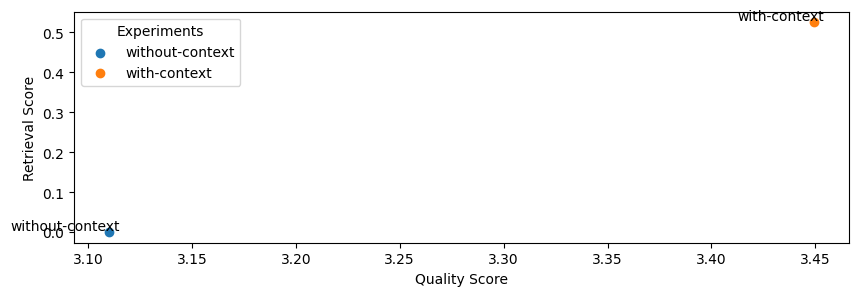

In [24]:
scores = {}
for experiment_name in ["without-context", "with-context"]:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

**Sanity check**: the retrieval score for without-context is zero since we’re using any context.

As we can see, using context (RAG) does indeed help in the quality of our answers (and by a meaningful margin).

### Chunk size

Next, we'll access various chunk sizes. Smaller chunks (but not too small!) are able to encapsulate atomic concepts which yields more precise retrieval. While larger chunks may be more noisy. Popular strategies include using small chunks but retrieving a bit of the [surrounding chunks](https://gpt-index.readthedocs.io/en/latest/end_to_end_tutorials/dev_practices/production_rag.html#decoupling-chunks-used-for-retrieval-vs-chunks-used-for-synthesis) around it (since it may have relevnat info) or store [mulitple embeddings](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) per document (ex. summary embedding per document).

In [100]:
chunk_sizes = [100, 300, 500, 700, 900]

In [ ]:
for chunk_size in chunk_sizes:
    experiment_name = f"chunk-size-{chunk_size}"
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=50, 
        num_chunks=5,
        embedding_model_name="thenlper/gte-base",
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

 94%|█████████▍| 166/177 [10:27<00:35,  3.21s/it]

In [101]:
experiment_names = []
for chunk_size in chunk_sizes:
    experiment_names.append(f"chunk-size-{chunk_size}")

chunk-size-100
  retrieval score: 0.4180790960451977
  quality score: 3.073446327683616

chunk-size-300
  retrieval score: 0.5254237288135594
  quality score: 3.3983050847457625

chunk-size-500
  retrieval score: 0.5480225988700564
  quality score: 3.5338983050847457

chunk-size-700
  retrieval score: 0.519774011299435
  quality score: 3.573446327683616

chunk-size-900
  retrieval score: 0.5706214689265536
  quality score: 3.531073446327684



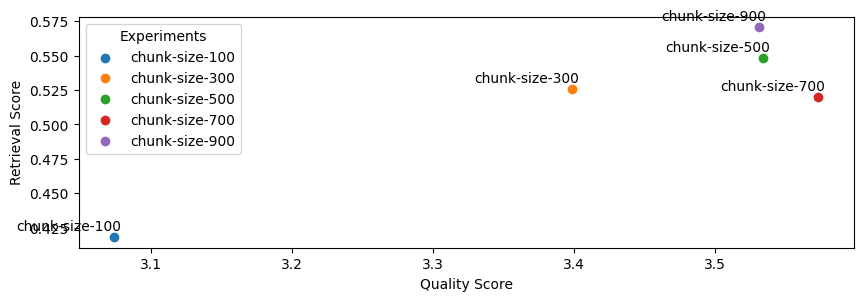

In [102]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

It appears that larger chunk sizes do help but tapers off (too much context might be too noisy). Larger chunk sizes [aren’t always better](https://arxiv.org/abs/2307.03172).

**Note**: If we were to use larger chunk sizes (ours is based on characters), keep in mind that [most](https://huggingface.co/spaces/mteb/leaderboard) open source embedding models have a maximum sequence length of 512 sub-word tokens. This means that if our chunk contains more than 512 sub-word tokens (4 chars ≈ 1 token), the embedding wouldn't account for it anyway (unless we finetune our embedding model to have longer sequence lengths).

In [58]:
CHUNK_SIZE = 500
CHUNK_OVERLAP = 50

### Number of chunks

Next, we'll experiment with the number of chunks to use. More chunks will allow us to add more context but too many could potentially introduce a lot of noise.

**Note**: The `chunk_size` we chose multiplied by the `num_chunks` below fits inside the LLM's context length. We're experimenting with the chunk size and number of chunks as if they were indepdent variables but they area heavily related. Especially since all of our LLMs have a finite maximum context length. So ideally, we would tune for a combination if `chunk_size` * `num_chunks`.

In [ ]:
num_chunks_list = [1, 3, 5, 7, 9]

In [ ]:
for num_chunks in num_chunks_list:
    experiment_name = f"num-chunks-{num_chunks}"
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=num_chunks,
        embedding_model_name="thenlper/gte-base",
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

In [105]:
experiment_names = []
for num_chunks in num_chunks_list:
    experiment_names.append(f"num-chunks-{num_chunks}")

num-chunks-1
  retrieval score: 0.20903954802259886
  quality score: 3.1045197740112993

num-chunks-3
  retrieval score: 0.4406779661016949
  quality score: 3.477401129943503

num-chunks-5
  retrieval score: 0.5480225988700564
  quality score: 3.5706214689265536

num-chunks-7
  retrieval score: 0.6214689265536724
  quality score: 3.6016949152542375

num-chunks-9
  retrieval score: 0.6779661016949152
  quality score: 3.437853107344633



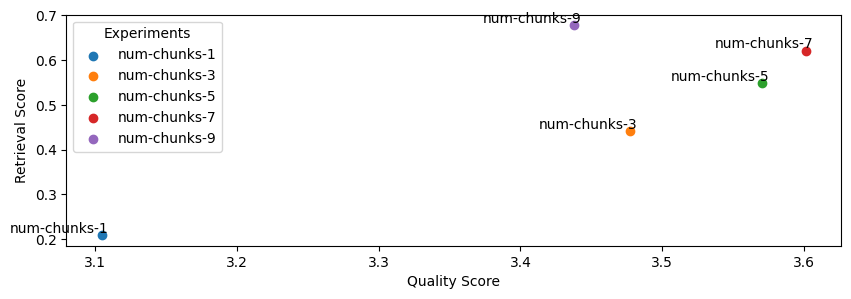

In [106]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

Increasing our number of chunks improves our retrieval and quality scores. We had to stop testing at 7 chunks since our `chunk_size` is 500 tokens and `Llama-2-70b`'s maximum content length is 4096 tokens (we also have to account for the system, assistant and user content to our LLM). This is a compelling reason to invest in extending context size via RoPE scaling (rotary position embeddings), etc. But it also seems that the benefit of increasing the number of chunks is starting to taper off.


In [59]:
NUM_CHUNKS = 7

### Embedding models

So far, we've used [thenlper/gte-base](https://huggingface.co/thenlper/gte-base) as our embedding model because it's a relatively small (0.22 GB) and performant option. But now, let's explore other popular options such as the current leader on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard), [BAAI/bge-large-en](https://huggingface.co/BAAI/bge-large-en) (1.34 GB), [thenlper/gte-large](https://huggingface.co/thenlper/gte-large) (a larger version of `gte-base`), and OpenAI's [text-embedding-ada-002](https://openai.com/blog/new-and-improved-embedding-model).

In [33]:
embedding_model_names = ["thenlper/gte-base", "thenlper/gte-large", "BAAI/bge-large-en", "text-embedding-ada-002"]

In [145]:
for embedding_model_name in embedding_model_names:
    experiment_name = f"{embedding_model_name.split('/')[-1]}"
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=embedding_model_name,
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [17:05<00:00,  5.80s/it]


In [147]:
experiment_names = []
for embedding_model_name in embedding_model_names:
    experiment_names.append(f"{embedding_model_name.split('/')[-1]}")

gte-base
  retrieval score: 0.6214689265536724
  quality score: 3.57909604519774

gte-large
  retrieval score: 0.6892655367231638
  quality score: 3.5847457627118646

bge-large-en
  retrieval score: 0.4406779661016949
  quality score: 3.3446327683615817

text-embedding-ada-002
  retrieval score: 0.5988700564971752
  quality score: 3.5112994350282487



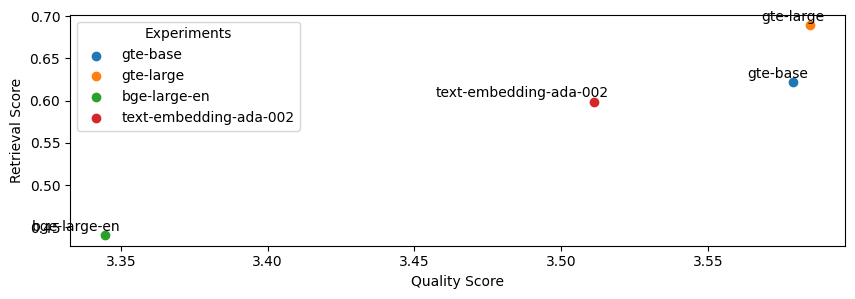

In [148]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

This is an interesting outcome because the #1 (`BAAI/bge-large-en`) on the current leaderboard isn't necessarily the best for our specific task. Using the smaller `thenlper/gte-base` produced the best retrieval and quality scores in our experiments.

In [60]:
EMBEDDING_MODEL_NAME = "thenlper/gte-large"

### OSS vs. closed LLMs

We're now going to use the best configurations from above to evaluate different choices for the main LLM.

**Note**:
- We've been using a specific LLM so far to decide on the configuration so that specific LLM's performance here will be a bit biased.
- This list is not exhaustive and even for the LLMs we use, there are versions with longer context windows available.

In [36]:
llms = ["gpt-3.5-turbo",
        "gpt-4",
        "meta-llama/Llama-2-7b-chat-hf", 
        "meta-llama/Llama-2-13b-chat-hf", 
        "meta-llama/Llama-2-70b-chat-hf",
        "tiiuae/falcon-180b"]

In [64]:
for llm in llms:
    experiment_name = f"{llm.split('/')[-1].lower()}"
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=EMBEDDING_MODEL_NAME,
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|██████████| 177/177 [20:22<00:00,  6.91s/it]


In [37]:
experiment_names = []
for llm in llms:
    experiment_names.append(f"{llm.split('/')[-1].lower()}")

In [38]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)

gpt-3.5-turbo
  retrieval score: 0.6214689265536724
  quality score: 3.57909604519774

gpt-4
  retrieval score: 0.6214689265536724
  quality score: 3.824858757062147

llama-2-7b-chat-hf
  retrieval score: 0.6214689265536724
  quality score: 2.864406779661017

llama-2-13b-chat-hf
  retrieval score: 0.6214689265536724
  quality score: 3.138418079096045

llama-2-70b-chat-hf
  retrieval score: 0.6214689265536724
  quality score: 3.4887005649717513

falcon-180b
  retrieval score: 0.6214689265536724
  quality score: 3.4804469273743015



**Sanity check**: the retrieval scores are all the same because the LLM we choose doesn’t impact that part of our application.

**Note**: Some of our LLMs have much larger context lengths, ex. `gpt-4` is 8192 tokens and `gpt-3.5-turbo-16k` is 16,384 tokens. We could increase the number of chunks that we use for these since we saw that increasing `num_chunks` continued to improve the retrieval and quality scores. However, we will keep this value fixed for now since the performance started to taper off anyway and so we can compare these performances under the exact same configurations.

In [61]:
LLM = "meta-llama/Llama-2-70b-chat-hf"

## Cost analysis

Besides just performance, we also want to evaluate the cost of our configurations (especially given the high price points of larger LLMs). We’re going to break this down into prompt and sampled pricing. The prompt size is the number of characters in our system, assistant and user contents (which includes the retrieved contexts). And the sampled size is the number of characters the LLM generated in its response.

**Note**: Our `Llama-2` models are priced at $1/M tokens with [Anyscale Endpoints](https://endpoints.anyscale.com/).

In [41]:
# Pricing per $1M/tokens
pricing = {
    "gpt-3.5-turbo": {
        "prompt": 2,
        "sampled": 2
    },
    "gpt-4": {
        "prompt": 60,
        "sampled": 30
    },
    "llama-2-7b-chat-hf": {
        "prompt": 0.25,
        "sampled": 0.25
    },
    "llama-2-13b-chat-hf": {
        "prompt": 0.5,
        "sampled": 0.5
    },
    "llama-2-70b-chat-hf": {
        "prompt": 1,
        "sampled": 1
    }
}

In [64]:
def cost_analysis(experiment_name):
    eval_fp = Path(ROOT_DIR, EXPERIMENTS_DIR, "evaluations", f"{experiment_name}_{EVALUATOR}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    num_samples = len(d["results"])
    prompt_size, sampled_size = 0, 0
    for result in d["results"]:
        prompt_size += len(result["question"]) + (CHUNK_SIZE * NUM_CHUNKS)
        sampled_size += len(result["generated_answer"])
    total_cost = pricing[experiment_name]["prompt"]/1e6 * prompt_size + pricing[experiment_name]["sampled"]/1e6 * sampled_size
    avg_cost = total_cost / num_samples
    
    print (experiment_name)
    print (f"  avg prompt size: {int(prompt_size/num_samples)}")
    print (f"  avg sampled size: {int(sampled_size/num_samples)}")
    print (f"  total cost: ${total_cost:.4f}")
    print (f"  avg cost: ${avg_cost:.4f}")
    print ()
    return avg_cost

In [53]:
for experiment_name in experiment_names[:-1]:
    scores[experiment_name]["average_cost"] = cost_analysis(experiment_name=experiment_name)

gpt-3.5-turbo
  avg prompt size: 3567
  avg sampled size: 852
  total cost: $1.5648
  avg cost: $0.0088

gpt-4
  avg prompt size: 3567
  avg sampled size: 677
  total cost: $41.4878
  avg cost: $0.2344

llama-2-7b-chat-hf
  avg prompt size: 3567
  avg sampled size: 2375
  total cost: $0.2630
  avg cost: $0.0015

llama-2-13b-chat-hf
  avg prompt size: 3567
  avg sampled size: 1619
  total cost: $0.4590
  avg cost: $0.0026

llama-2-70b-chat-hf
  avg prompt size: 3567
  avg sampled size: 1476
  total cost: $0.8928
  avg cost: $0.0050



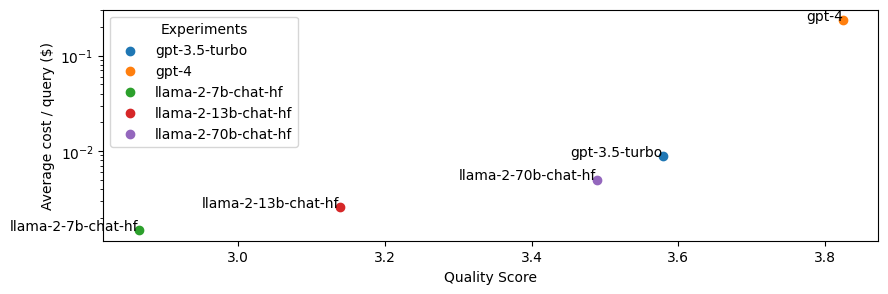

In [57]:
# Prepare data for plotting
experiment_names = list(scores.keys())[:-1]
average_costs = [scores[experiment_name]["average_cost"] for experiment_name in experiment_names]
quality_scores = [scores[experiment_name]["quality_score"] for experiment_name in experiment_names]

# Plotting
plt.figure(figsize=(10, 3))
for i, experiment_name in enumerate(experiment_names):
    plt.scatter(quality_scores[i], average_costs[i], label=experiment_name)
    plt.text(quality_scores[i], average_costs[i], experiment_name, ha="right")

# Add labels and title
plt.xlabel("Quality Score")
plt.ylabel("Average cost / query ($)")
plt.legend(title="Experiments")
plt.yscale("log")

# Show the plot
plt.show()

## Routing

It seems that the most performant LLM is also the most expensive one (`gpt-4`) by 15X. However, we want to be able to serve the most performant and cost-effective solution. We can close this gap in performance between open source and proprietary models by routing queries to the right model according to the complexity or topic of the query. For example, in our application, open source models perform really well on simple queries where the answer can be easily inferred from the retrieved context. However, the OSS models fall short for queries that involve reasoning, numbers or code examples. To identify the appropriate LLM to use, we can train a classifier that takes the query and routes it to the best model.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/7FWrvPPlIdz5fs8wQgxLFz/fdae368044275028f0544a3d252fcfe4/image15.png">

**Note**: In part 2 of this series, we’ll fine-tune our embedding models and OSS LLMs to make them even more performant.

In order to implement this, we hand-annotated a [dataset of 1.8k queries](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-train.jsonl) according to which model (`gpt-4` (label=0) or `Llama-2-70b` (label=1)) would be appropriate -- by default we route to `Llama-2-70b` and only if the query needs more advanced capabilities do we send the query to `gpt-4`. We then evaluate the performance of the model on a test set that has been scored with an evaluator.

In [62]:
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline

Let's first train the model on the training dataset [routing-dataset-training.jsonl](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-train.jsonl):

In [55]:
with open(Path(ROOT_DIR, "datasets", "routing-dataset-train.jsonl")) as f:
    records = [json.loads(l) for l in f]
    texts = [record["question"] for record in records]
    labels = [record["target"] for record in records]

In [56]:
# Sample records (1 = can be handled by OSS LLM)
print ("Question for gpt-4:\n", [record for record in records if record["target"] == 0][0]) 
print ("\nQuestion for Llama-2-70b:\n", [record for record in records if record["target"] == 1][0])

Question for GPT-4:
 {'question': 'if I am inside of a anyscale cluster how do I get my cluster-env-build-id', 'target': 0}

Question for Llama-2-70b:
 {'question': 'what is num_samples in tune?', 'target': 1}


In [57]:
# Train classifier
vectorizer = CountVectorizer()
classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs")
router = Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
router.fit(texts, labels)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(multi_class='multinomial'))])

Now let's evaluate the performance on the [test dataset](https://github.com/ray-project/llm-applications/blob/main/datasets/routing-dataset-test.jsonl):

In [58]:
with open(Path(ROOT_DIR, "datasets", "routing-dataset-test.jsonl")) as f:
    records = [json.loads(line) for line in f]
    texts = [record["question"] for record in records]
    y_test = [record["target"] for record in records]
    score_test = [record["score"] for record in records]

In [59]:
# Predictions
y_pred = router.predict(texts)

In [60]:
metrics = {}
performance = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["precision"] = performance[0]
metrics["recall"] = performance[1]
metrics["f1"] = performance[2]
metrics["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics, indent=4))

{
    "precision": 0.917778649921507,
    "recall": 0.9285714285714286,
    "f1": 0.9215235703917096,
    "num_samples": 574.0
}


In [58]:
print ("# total samples", len(y_pred))
print(f"# samples for OSS models: {sum(y_pred)} ({sum(y_pred)*100/len(y_pred):.1f}%)")
print("Performance on samples predicted for Llama-2-70b:", np.mean([score_test[i] for i, p in enumerate(y_pred) if p]))
print("Performance on samples predicted for gpt-4:", np.mean([score_test[i] for i, p in enumerate(y_pred) if not p]))

# total samples 574
# samples for OSS models: 546 (95.1%)
Avg. score for samples predicted for Llama-2-70b: 3.8653846153846154
Avg. score for samples predicted for gpt-4: 3.625


**Note**: For our dataset, a small logistic regression model is good enough to perform the routing. But if your use case is more complex, consider training a more complex model, like a BERT-based classifier to perform the classification. These models are still small enough that wouldn’t introduce too much latency. Be sure to check out this [guide](https://github.com/GokuMohandas/Made-With-ML) if you want to learn how to train and deploy supervised deep learning models.

In [62]:
# Inference
query = "Give me the code for getting results from a training run"
router.predict([query])[0]

0

In [63]:
# Save
router_fp = Path(ROOT_DIR, "datasets", "router.pkl")
with open(router_fp, "wb") as file:
    pickle.dump(router, file)

In [64]:
# Load
with open(router_fp, "rb") as file:
    router = pickle.load(file)

## Serving

Now we're ready to start serving our Ray Assistant using our best configuration. We're going to use [Ray Serve](https://docs.ray.io/en/latest/serve/index.html) with [FastAPI](https://fastapi.tiangolo.com/) to develop and scale our service. First, we'll define some data structures like `Query` and `Answer` to represent the inputs and outputs to our service. We will also define a small function to load our index (assumes that the respective SQL dump file already exists). Finally, we can define our `QueryAgent` and use it to serve `POST` requests with the query. And we can serve our agent at any deployment scale we wish using the [@serve.deployment](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.Deployment.html) decorator where we can specify the number of replicas, compute resources, etc.

In [65]:
import requests
from typing import List

In [66]:
from fastapi import FastAPI
from pydantic import BaseModel
from ray import serve
from rag.index import load_index

In [67]:
# Initialize application
app = FastAPI()

In [68]:
class Query(BaseModel):
    query: str

In [69]:
class Answer(BaseModel):
    question: str
    sources: List[str]
    answer: str
    llm: str

In [70]:
router_fp = Path(ROOT_DIR, "datasets", "router.pkl")
with open(router_fp, "rb") as file:
    router = pickle.load(file)

In [71]:
@serve.deployment(route_prefix="/", num_replicas=1, ray_actor_options={"num_cpus": 28, "num_gpus": 2})
@serve.ingress(app)
class RayAssistantDeployment:
    def __init__(self, chunk_size, chunk_overlap, num_chunks, embedding_model_name, llm):
        # Set up
        load_index(
            embedding_model_name=embedding_model_name,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap)

        # Query agent
        self.num_chunks = num_chunks
        system_content = "Answer the query using the context provided. Be succint."
        self.oss_agent = QueryAgent(llm=llm, max_context_length=MAX_CONTEXT_LENGTHS[llm], system_content=system_content)
        self.gpt_agent = QueryAgent(llm="gpt-4", max_context_length=MAX_CONTEXT_LENGTHS["gpt-4"], system_content=system_content)
            
        # Router
        router_fp = Path(ROOT_DIR, "datasets", "router.pkl")
        with open(router_fp, "rb") as file:
            self.router = pickle.load(file)

    @app.post("/query")
    def query(self, query: Query) -> Answer:
        use_oss_agent = self.router.predict([query.query])[0]
        agent = self.oss_agent if use_oss_agent else self.gpt_agent
        result = agent(query=query.query, num_chunks=self.num_chunks, stream=False)
        return Answer.parse_obj(result)

Note: As we can see, Ray Serve makes [model composition](https://docs.ray.io/en/latest/serve/model_composition.html) extremely easy and we could continue to make this more fine-grained. For example, we can train a classifier to discern between queries for `Llama-2-70b`,` CodeLlama-34b-Instruct-hf` (for code generation) and `gpt-4` (for highly complex queries). Also, we can use streaming end-to-end to reduce the time a user has to wait for the answer. Check out the `/stream` method in `rag/serve.py`.

In [72]:
# Deploy the Ray Serve application.
deployment = RayAssistantDeployment.bind(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    num_chunks=NUM_CHUNKS,
    embedding_model_name=EMBEDDING_MODEL_NAME,
    llm=LLM)
serve.run(deployment)

(ServeController pid=883400) INFO 2023-09-10 23:35:47,404 controller 883400 deployment_state.py:1308 - Deploying new version of deployment default_RayAssistantDeployment.
(HTTPProxyActor pid=883470) INFO:     Started server process [883470]
(ServeController pid=883400) INFO 2023-09-10 23:35:47,507 controller 883400 deployment_state.py:1571 - Adding 1 replica to deployment default_RayAssistantDeployment.
2023-09-10 23:36:10,433	INFO router.py:853 -- Using PowerOfTwoChoicesReplicaScheduler.
2023-09-10 23:36:10,440	INFO router.py:329 -- Got updated replicas for deployment default_RayAssistantDeployment: {'default_RayAssistantDeployment#bZVeMN'}.


RayServeSyncHandle(deployment='default_RayAssistantDeployment')

In [73]:
# Inference
data = {"query": "What is the default batch size for map_batches?"}
response = requests.post("http://127.0.0.1:8000/query", json=data)
print(response.json())

(ServeReplica:default_RayAssistantDeployment pid=883545) The default batch size
(ServeReplica:default_RayAssistantDeployment pid=883545)  for
(ServeReplica:default_RayAssistantDeployment pid=883545)  map_batch
(ServeReplica:default_RayAssistantDeployment pid=883545) es
(ServeReplica:default_RayAssistantDeployment pid=883545)  is 4
(ServeReplica:default_RayAssistantDeployment pid=883545) 0
(ServeReplica:default_RayAssistantDeployment pid=883545) 9
(ServeReplica:default_RayAssistantDeployment pid=883545) 6
(ServeReplica:default_RayAssistantDeployment pid=883545) .
{'question': 'What is the default batch size for map_batches?', 'sources': ['https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches', 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size', 'https://docs.ray.io/en/master/data/data-internals.html#execution-memory', 'https://docs.ray.io/en/master/serve/advanced-guides/dyn-req-batch.html#tips-for-fine-t

Once our application is served, we’re free to use it anywhere we want. For example, we use it as a bot on our Slack channels and as a widget on our docs page (public release coming soon). We can use this to collect feedback from our users to continually improve the application (fine-tuning, UI/UX, etc.).

<img width="600" src="https://images.ctfassets.net/xjan103pcp94/7pyW8T7La5T51C8iXEwmAO/71b844d6931e47f41b83da84cf058e9b/how-can-i-parallelize-a-function.png">

In [74]:
# Shutdown
serve.shutdown()

(ServeController pid=883400) INFO 2023-09-10 23:36:14,879 controller 883400 deployment_state.py:1595 - Removing 1 replica from deployment 'default_RayAssistantDeployment'.
(ServeReplica:default_RayAssistantDeployment pid=883545) INFO 2023-09-10 23:36:14,845 default_RayAssistantDeployment default_RayAssistantDeployment#bZVeMN AAQsmDrBNj /query default replica.py:723 - __CALL__ OK 4382.8ms
2023-09-10 23:36:14,884	INFO router.py:329 -- Got updated replicas for deployment default_RayAssistantDeployment: set().


# Impact

## 1st order

Building an LLM application like this has had a tremendous impact on our products and company. There were expected 1st order impacts in overall developer and user adoption for our products. The capability to interact and solve problems that our users experience in a self-serve and immediate manner is the type of feature that would improve the experience of any product. It makes it significantly easier for people to succeed and it elevated the perception around LLM applications from a nice-to-have to a must-have. 

## 2nd order

However, there were also some 2nd order impacts that we didn’t immediately realize. For example, when we further inspected user queries that yielded poor scores, often the issue existed because of a gap in our documentation. When we made the fix (ex. added the appropriate section to our docs), this improved our product and the LLM application itself — creating a very valuable feedback flywheel. Furthermore, when internal teams learned of the capabilities of our LLM application, this generated the development of highly valuable LLM applications that depend on this Ray docs LLM application as one of its foundational agents that it uses to perform its tasks.

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/2UF2tSV3kmXtrzmqMsYrLF/76bcc71b481986eb6cb3b06d60582ec5/image18.png">

For example, we’ve internally developed a feature called Anyscale Doctor that helps developers diagnose and debug issues during development. Issues in code can be caused by a variety of reasons but when the issue is Ray related, the LLM application we built here is called to aid in resolving the particular issue.

# Advanced

## Fine-tuned embeddings

In [63]:
import json
import random
from sentence_transformers import InputExample, SentenceTransformer
from torch.utils.data import DataLoader

In [3]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [68]:
embedding_model._modules

OrderedDict([('0',
              Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel ),
             ('1',
              Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})),
             ('2', Normalize())])

In [69]:
num_questions = 1000

In [70]:
sections = sections_ds.take_all()
len(sections)

5727

In [71]:
sections[0]

{'source': 'https://docs.ray.io/en/master/ray-observability/reference/index.html#reference',
 'text': '\nReference#\nMonitor and debug your Ray applications and clusters using the API and CLI documented in these references.\nThe guides include:\nState API\nState CLI\nSystem Metrics\n'}

In [72]:
system_content = f"""
Create one question using only the context provided.
End each question with a '?' character.
"""

In [ ]:
# Generate questions
embedding_qa = []
num_questions = 1000
sampled_sections = random.sample(sections, num_questions)
for section in tqdm(sampled_sections):
    response = generate_response(
        llm="gpt-3.5-turbo",
        temperature=0.0,
        stream=False,
        system_content=system_content,
        user_content=f"context: {section['text']}")
    embedding_qa.append({"question": response, "source": section["source"]})

In [146]:
len(embedding_qa)  # some contexts were too long

908

In [64]:
# Path
EMBEDDING_QA_FILE_PATH = Path(ROOT_DIR, "datasets", "embedding_qa.json")
EMBEDDING_QA_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
# Save to file
with open(EMBEDDING_QA_FILE_PATH, "w") as fp:
    json.dump(embedding_qa, fp, indent=4)

In [65]:
# Load from file
with open(EMBEDDING_QA_FILE_PATH, "r") as fp:
    embedding_qa = json.load(fp)

In [75]:
# Training dataset
train_dataset = []
for item in tqdm(embedding_qa):
    query = item["question"]
    text = fetch_text(item["source"])
    example = InputExample(texts=[query, text])
    train_dataset.append(example)

100%|██████████| 908/908 [00:48<00:00, 18.78it/s]


In [66]:
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.evaluation import InformationRetrievalEvaluator

Our validation evaluation criteria involves an IR evaluator that will retrieve the top k similar documents from the corpus for each query. The [InformationRetrievalEvaluator](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/evaluation/InformationRetrievalEvaluator.py#L16) requires the following inputs:

- queries: `Dict[str, str]`  #  qid => query
- corpus: `Dict[str, str]`  #  cid => doc
- relevant_docs: `Dict[str, Set[str]]`  #  qid => Set[cid]

In [67]:
# Reference (for validation)
REFERENCES_FILE_PATH = Path(EXPERIMENTS_DIR, "references", "gpt-4.json")
with open(REFERENCES_FILE_PATH, "r") as fp:
    references = json.load(fp)
references[0]

{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
 'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format',
 'answer': "You can specify the batch format in the map_batches() function. If you're working with NumPy ndarrays, your function should accept and return a dictionary of ndarrays. If you're working with pandas DataFrames, your function should accept and return a DataFrame. Make sure your function is correctly handling the data type you've specified in batch_format.",
 'score': 4.0,
 'reasoning': "The answer provides a solution to the problem by explaining how to use the batch_format parameter in the map_batches() function. However, it doesn't provide specific examples or potential error scenarios that might be causing the user's issue, hence the score is not a full 5."}

In [78]:
# Validation dataset
queries = {f"qid_{i}": item["question"] for i, item in enumerate(references)}
corpus = {f"cid_{i}": fetch_text(item["source"]) for i, item in enumerate(references)}
relevant_docs = {f"qid_{i}": set(f"cid_{i}") for i, item in enumerate(references)}
evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [79]:
loss = MultipleNegativesRankingLoss(embedding_model)

In [80]:
# Train dataloader
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

In [81]:
num_epochs = 2
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
warmup_steps

181

In [83]:
# # Clean up
# import gc
# import torch
# del embedding_model
# gc.collect()
# torch.cuda.empty_cache()

In [68]:
gte_large_ft_path = str(Path(EFS_DIR, "gte-large-ft"))

In [85]:
# Train
embedding_model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=gte_large_ft_path,
    show_progress_bar=True,
    evaluator=evaluator, 
    evaluation_steps=50,
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/908 [00:00<?, ?it/s]

Iteration:   0%|          | 0/908 [00:00<?, ?it/s]

In [72]:
experiment_name = "gte-large-fine-tuned"
run_experiment(
    experiment_name=experiment_name, 
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=CHUNK_OVERLAP, 
    num_chunks=NUM_CHUNKS,
    embedding_model_name=gte_large_ft_path,
    embedding_dim=EMBEDDING_DIMENSIONS[EMBEDDING_MODEL_NAME],
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

Exception ignored in: <function StreamingExecutor.__del__ at 0x7effd83136d0>
Traceback (most recent call last):
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/data/_internal/execution/streaming_executor.py", line 147, in __del__
    self.shutdown()
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/data/_internal/execution/streaming_executor.py", line 160, in shutdown
    self.join(timeout=2.0)
  File "/home/ray/anaconda3/lib/python3.10/threading.py", line 1091, in join
    raise RuntimeError("cannot join thread before it is started")
RuntimeError: cannot join thread before it is started
2023-10-09 18:31:08,803	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-10-09 18:31:08,804	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionRes

(autoscaler +8m51s) [autoscaler] There are 4 infeasible resource request(s). Note that each resource bundle can only be scheduled on a node with sufficient resources. Add node types with sufficient resources and try again. Requests: 
4 * {"resourcesBundle":{"CPU":1, "GPU":1}};


KeyboardInterrupt: 

In [ ]:
embedding_model_names = ["thenlper/gte-base", "thenlper/gte-large", "BAAI/bge-large-en", "text-embedding-ada-002", "gte-large-fine-tuned"]
experiment_names = []
for embedding_model_name in embedding_model_names:
    experiment_names.append(f"{embedding_model_name.split('/')[-1]}")

In [ ]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

# Next steps

In the next guide (part II), we’ll discuss how we continuously keep our RAG application up to date as our data sources grow and how to leverage the feedback from production to fine-tune our embedding models and LLMs.

- add additional context with retrieved chunks
- keyword search with semantic (embedding) search
- reranking with LLM on retrieved chunks (from embeddings)
- fine-tune embedding model
- fine-tune base LLM (OSS) with Anyscale Endpoints
- longer context lengths (RoPE)
- structuring and updating the index in the vector DB
- offline/online indexing of new data

# Learn more

- If your team is investing heavily in developing LLM applications, [reach out](mailto: endpoints-help@anyscale.com) to us to learn more about how [Ray](https://github.com/ray-project/ray) and [Anyscale](http://anyscale.com/) can help you scale and productionize everything.
- Start serving (+fine-tuning) OSS LLMs with [Anyscale Endpoints](https://endpoints.anyscale.com/) ($1/M tokens for `Llama-2-70b`) and private endpoints available upon request (1M free tokens trial). 
- Learn more about how companies like OpenAI, Netflix, Pinterest, Verizon, Instacart and others leverage Ray and Anyscale for their AI workloads at the [Ray Summit 2023](https://raysummit.anyscale.com/) this Sept 18-20 in San Francisco.
